In [30]:
!pip install openpyxl

In [31]:
import datetime
import numpy as np
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [32]:
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx', engine="openpyxl")

In [33]:
df.head(20)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [34]:
 df.describe()

,Quantity,Price,Customer ID
count,525461.000000,525461.000000,417534.000000
mean,10.337667,4.688834,15360.645478
std,107.424110,146.126914,1680.811316
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13983.000000
50%,3.000000,2.100000,15311.000000
75%,10.000000,4.210000,16799.000000
max,19152.000000,25111.090000,18287.000000


In [35]:
#결측치의 합계를 구해서 내림차순으로 정렬하기
df.isnull().sum().sort_values(ascending=False)

Customer ID    107927
Description      2928
Invoice             0
StockCode           0
Quantity            0
InvoiceDate         0
Price               0
Country             0
dtype: int64

In [36]:
#제품 수량과 가격이 0 이하인 데이터 제거
df = df[(df['Quantity']>0) & (df['Price']>0)]

#중복 데이터 제거하기
df = df.drop_duplicates()

In [37]:
#Recency 구매 최신성 Frequency 구매 빈도 Monetary 구매 금액 RFM 지표

In [38]:
#Recency 계산하기 위해 마지막 날짜의 다음 날 계산하기
last_date = df.InvoiceDate.max() + datetime.timedelta(days=1)

#구매 수량과 제품 가격을 곱하여 구매 금액 계산하기
df['Amount'] =df['Quantity'] * df['Price']

#Groupby 함수로 고객별로 최근 구매 경과일, 구매 건수, 구매 금액 합계 구하기
rfm = df.groupby('Customer ID').agg(
{'InvoiceDate' : lambda InvoiceDate: (last_date - InvoiceDate.max()).days,
'Invoice' : lambda Invoice :Invoice.nunique(), 
'Amount' : lambda Amount : Amount.sum()})

rfm.head()

,InvoiceDate,Invoice,Amount
Customer ID,,,
12346.0,165,11,372.86
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,3,2671.14
12351.0,11,1,300.93


In [39]:
#데이터프레임의 칼럼명 변경하기
rfm.columns = ['recency', 'frequency', 'monetary']
rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.0,165,11,372.86
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,3,2671.14
12351.0,11,1,300.93


In [40]:
#r,f,m 1~5까지 점수로 환산하기
rfm['recency_score'] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['frequency_score'] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm['monetary_score'] = pd.qcut(rfm['monetary'], 5, labels=[1,2,3,4,5]).astype(int)

#r,f,m 환산 점수 합계를 고객 점수로 저장
rfm['customer_score'] = rfm['recency_score'] + rfm['frequency_score'] + rfm['monetary_score']
rfm.head(10)

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,customer_score
Customer ID,,,,,,,
12346.0,165,11,372.86,2,5,2,9
12347.0,3,2,1323.32,5,2,4,11
12348.0,74,1,222.16,2,1,1,4
12349.0,43,3,2671.14,3,3,5,11
12351.0,11,1,300.93,5,1,2,8
12352.0,11,2,343.80,5,2,2,9
12353.0,44,1,317.76,3,1,2,6
12355.0,203,1,488.21,1,1,2,4
12356.0,16,3,3560.30,4,3,5,12


In [41]:
#고객 점수 만점인 고객 ID 확인하기
rfm[rfm['customer_score']==15].sort_values('monetary', ascending=False).head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,customer_score
Customer ID,,,,,,,
18102.0,1,89,349164.35,5,5,5,15
14646.0,10,78,248396.50,5,5,5,15
14156.0,7,102,196549.74,5,5,5,15
14911.0,1,205,152121.22,5,5,5,15
13694.0,9,94,131443.19,5,5,5,15


In [42]:
#고객 등급 분류 함수 만들기
def level(score):
    if score > 12:
        return 'VIP'
    elif 9 < score <= 12:
        return 'GOLD'
    elif 5 < score <= 9:
        return 'SILVER'
    else:
        return 'WHITE'
#고객 등급 분류 함수를 적용하여 고객 등급(level) 데이터 생성하기
rfm['level'] = rfm['customer_score'].apply(lambda customer_score : level(customer_score))
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,customer_score,level
Customer ID,,,,,,,,
12346.0,165,11,372.86,2,5,2,9,SILVER
12347.0,3,2,1323.32,5,2,4,11,GOLD
12348.0,74,1,222.16,2,1,1,4,WHITE
12349.0,43,3,2671.14,3,3,5,11,GOLD
12351.0,11,1,300.93,5,1,2,8,SILVER


<Axes: xlabel='level', ylabel='count'>

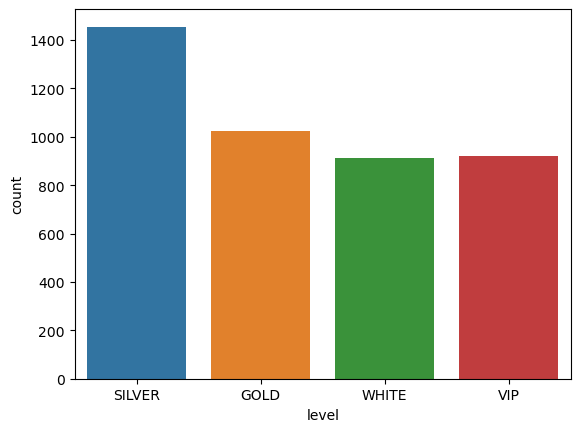

In [43]:
sns.countplot(x=rfm['level'])

In [44]:
rfm.describe()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,customer_score
count,4312.000000,4312.000000,4312.000000,4312.000000,4312.000000,4312.000000,4312.000000
mean,91.171846,4.455705,2040.406712,3.024814,3.000000,3.000000,9.024814
std,96.860633,8.170213,8911.755977,1.424049,1.414706,1.414706,3.584884
min,1.000000,1.000000,2.950000,1.000000,1.000000,1.000000,3.000000
25%,18.000000,1.000000,307.187500,2.000000,2.000000,2.000000,6.000000
50%,53.000000,2.000000,701.615000,3.000000,3.000000,3.000000,9.000000
75%,136.000000,5.000000,1714.932500,4.000000,4.000000,4.000000,12.000000
max,374.000000,205.000000,349164.350000,5.000000,5.000000,5.000000,15.000000


In [45]:
#k-평균 군집화 알고리즘 이용한 고객 분류하기

In [46]:
#이상치 제거 함수 작성하기
def processing_outlier(df, col_nm):
    Q1 = df[col_nm].quantile(0.25)
    Q3 = df[col_nm].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[col_nm] >= Q1 - 1.5*IQR) & (df[col_nm] >= Q3 + 1.5*IQR)]
    return df

In [47]:
#비교를 위해 이상치 제거 전 데이터 저장
rfm_tmp = rfm.copy()

{'whiskers': [<matplotlib.lines.Line2D at 0x2cbe3a1bc90>,
 'caps': [<matplotlib.lines.Line2D at 0x2cbe3a1ae90>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cbd70ef490>],
 'medians': [<matplotlib.lines.Line2D at 0x2cbe1b0e250>],
 'fliers': [<matplotlib.lines.Line2D at 0x2cbd70605d0>],
 'means': []}

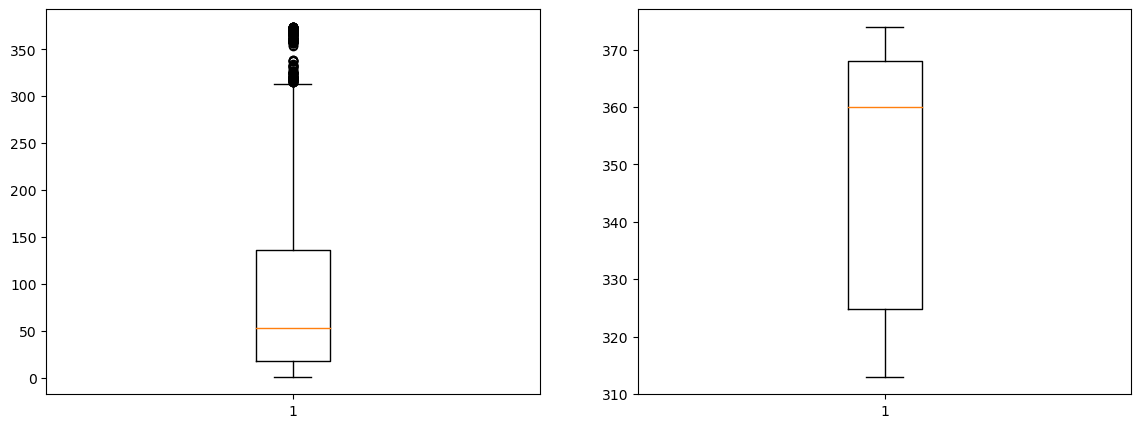

In [48]:
#recency 이상치 제거
rfm = processing_outlier(rfm, 'recency')

#이상치 제거 전후 비교하기
fig = plt.figure(figsize=(14,5)) #그림 사이즈 지정(가로 14 세로 5인치)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

#이상치 제거 전 그래프 시각화
ax1.boxplot(rfm_tmp.recency)

#이상치 제거 후 그래프 시각화
ax2.boxplot(rfm.recency)

{'whiskers': [<matplotlib.lines.Line2D at 0x2cbdf785910>,
 'caps': [<matplotlib.lines.Line2D at 0x2cbe19ae090>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cbda878150>],
 'medians': [<matplotlib.lines.Line2D at 0x2cbd75e3ad0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2cbd75e39d0>],
 'means': []}

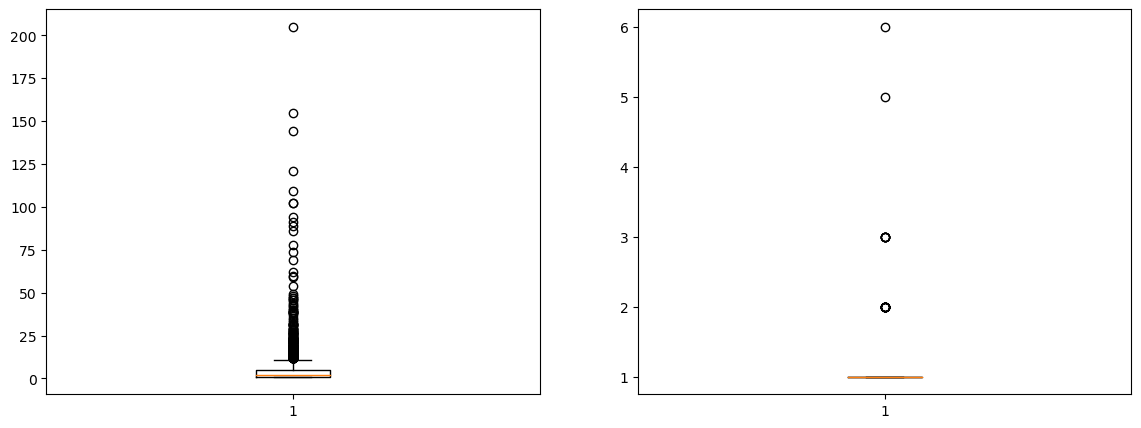

In [49]:
#frequency 이상치 제거
rfm = processing_outlier(rfm, 'frequency')

#이상치 제거 전후 비교하기
fig = plt.figure(figsize=(14,5)) #그림 사이즈 지정(가로 14 세로 5인치)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

#이상치 제거 전 그래프 시각화
ax1.boxplot(rfm_tmp.frequency)

#이상치 제거 후 그래프 시각화
ax2.boxplot(rfm.frequency)

{'whiskers': [<matplotlib.lines.Line2D at 0x2cbda9b6110>,
 'caps': [<matplotlib.lines.Line2D at 0x2cbdf192250>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cbd76251d0>],
 'medians': [<matplotlib.lines.Line2D at 0x2cbdf192210>],
 'fliers': [<matplotlib.lines.Line2D at 0x2cbdf190fd0>],
 'means': []}

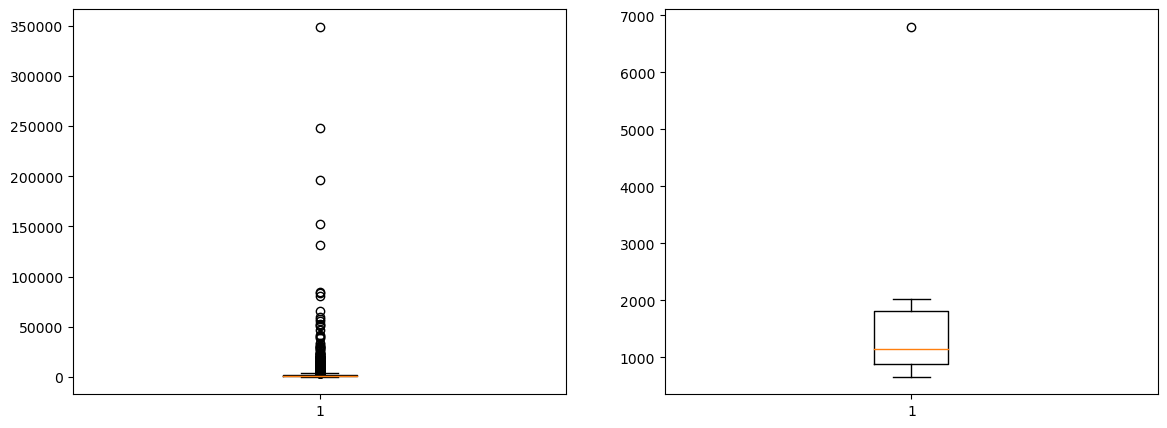

In [50]:
#monetary 이상치 제거
rfm = processing_outlier(rfm, 'monetary')

#이상치 제거 전후 비교하기
fig = plt.figure(figsize=(14,5)) #그림 사이즈 지정(가로 14 세로 5인치)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

#이상치 제거 전 그래프 시각화
ax1.boxplot(rfm_tmp.monetary)

#이상치 제거 후 그래프 시각화
ax2.boxplot(rfm.monetary)

In [51]:
rfm_k = rfm[['recency', 'frequency', 'monetary']]

#데이터 표준화하기
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_k)
print(rfm_scaled)

[[-0.96935226 -0.15113782 -0.32533556]
 [-0.79553737 -0.80606835  0.10133938]
 [-1.09971343  2.46858434  0.2355582 ]
 [ 1.07297268 -0.15113782  0.20912757]
 [ 1.15988012 -0.80606835 -0.43838422]
 [ 1.46405617 -0.15113782 -0.3002393 ]
 [-1.09971343 -0.80606835 -0.63254601]
 [-0.36100015 -0.80606835 -0.63578633]
 [ 0.94261151 -0.15113782 -0.49656366]
 [-1.05625971  0.50379272  0.01703724]
 [-0.0568241  -0.80606835 -0.47715127]
 [-0.57826876  1.8136538   3.30299886]
 [ 1.37714873 -0.15113782 -0.5600549 ]]


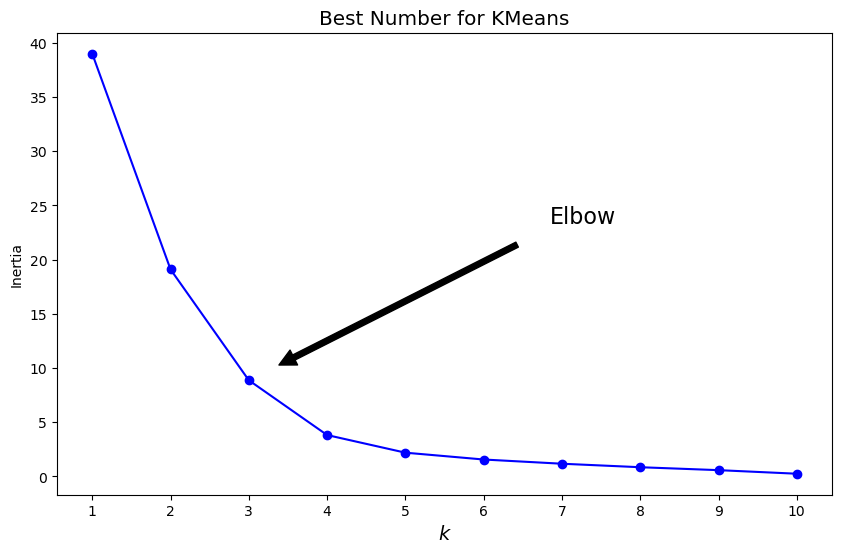

In [52]:
ks = range(1, 11)
inertias = []
for k in ks :
    kc = KMeans(n_clusters=k, random_state=42)
    kc.fit(rfm_scaled)
    cluster = kc.fit_predict(rfm_scaled)
    inertias.append(kc.inertia_)

# k vs inertia 그래프 그리기
plt.subplots(figsize=(10, 6))
plt.plot(ks, inertias, "bo-")
plt.xlabel("$k$", fontsize = 14)
plt.ylabel('Inertia')
plt.annotate('Elbow', xy=(3, inertias[2]), xytext=(0.55, 0.55), textcoords='figure fraction', fontsize=16, arrowprops = dict(facecolor='black', shrink=0.1))
plt.xticks(ks)
plt.style.use('ggplot')
plt.title('Best Number for KMeans')
plt.show()

In [53]:
#K를 3으로 설정하고 군집 중심 찾기
kc = KMeans(3, random_state=42)
kc.fit(rfm_scaled)
identified_clusters = kc.fit_predict(rfm_k)
clusters_scaled = rfm_k.copy()
clusters_scaled['cluster_pred'] = kc.fit_predict(rfm_scaled)

print(f'Identified Clusters : {identified_clusters}')
print(f'Cluster Centers : \n{kc.cluster_centers_}')

Identified Clusters : [0 2 2 2 0 0 0 0 0 2 0 1 0]
Cluster Centers : 
[[ 1.20333384 -0.28212392 -0.3172229 ]
 [-0.7231145  -0.47860309 -0.32540709]
 [-0.8389911   2.14111907  1.76927853]]


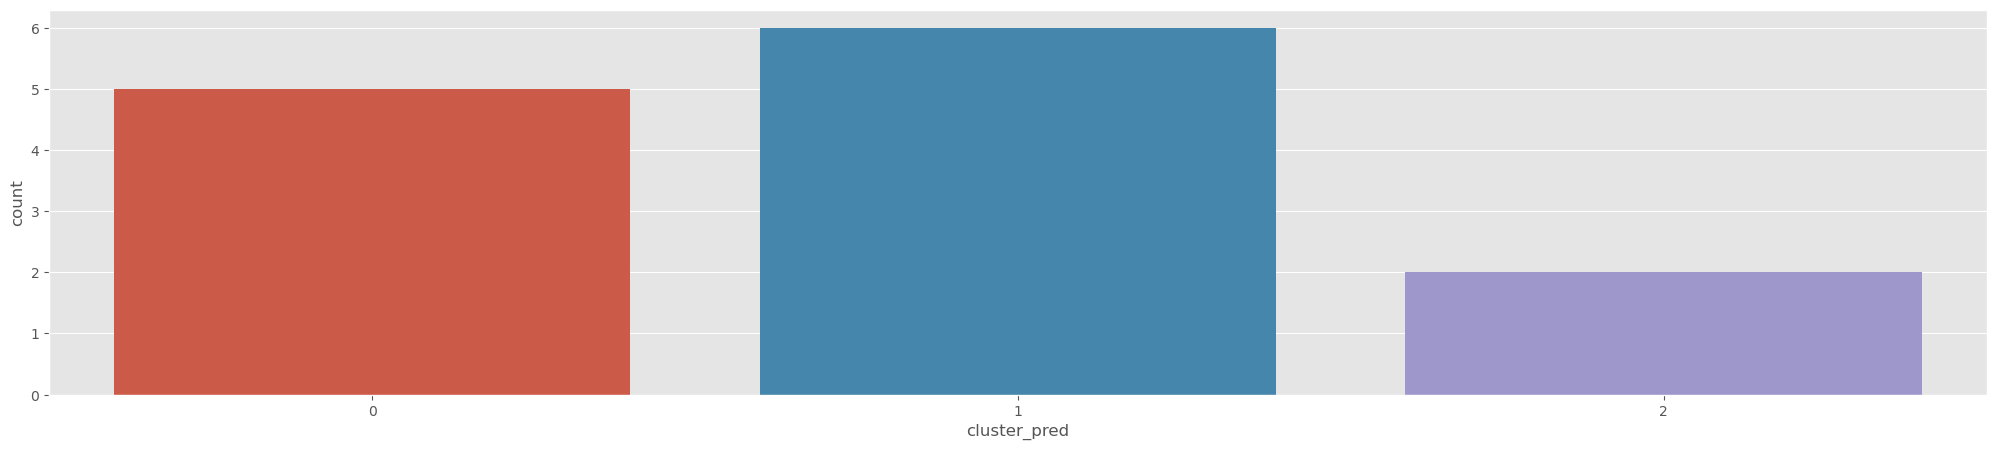

In [54]:
#cluster_pred 칼럼의 값별로 count하기
f, ax = plt.subplots(figsize=(25,5))
ax = sns.countplot(x='cluster_pred', data = clusters_scaled)

In [55]:
#pandas groupby 함수로 cluster_pred별 개수 집계하기
print(clusters_scaled.groupby(['cluster_pred']).count())

              recency  frequency  monetary
cluster_pred                              
0                   5          5         5
1                   6          6         6
2                   2          2         2


In [57]:
rfm_k['cluster'] = clusters_scaled['cluster_pred']
rfm_k['level'] = rfm['level']

#r,f,m 의 평균값, 최솟값, 최댓값 구하기
rfm_k.groupby('cluster').agg({
    'recency' : ['mean', 'min', 'max'],
    'frequency' : ['mean', 'min', 'max'],
    'monetary' : ['mean', 'min', 'max', 'count']
})

recency           frequency           monetary                    \
               mean  min  max      mean min max       mean      min      max   
cluster                                                                        
0        368.000000  362  374       1.8   1   2  1155.5260   777.00  1976.00   
1        323.666667  315  339       1.5   1   3  1142.7685   658.95  1807.98   
2        321.000000  315  327       5.5   5   6  4407.9600  2017.20  6798.72   

               
        count  
cluster        
0           5  
1           6  
2           2